In [ ]:
import nltk
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
#libraries for machne Learning (Vader, etc..)
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import string
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
flight_df = pd.read_csv("Airline_review.csv")

In [ ]:
flight_df.info()
summary_stats = flight_df.describe()
flight_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              23171 non-null  int64  
 1   Airline Name            23171 non-null  object 
 2   Overall_Rating          23171 non-null  object 
 3   Review_Title            23171 non-null  object 
 4   Review Date             23171 non-null  object 
 5   Verified                23171 non-null  bool   
 6   Review                  23171 non-null  object 
 7   Aircraft                7129 non-null   object 
 8   Type Of Traveller       19433 non-null  object 
 9   Seat Type               22075 non-null  object 
 10  Route                   19343 non-null  object 
 11  Date Flown              19417 non-null  object 
 12  Seat Comfort            19016 non-null  float64
 13  Cabin Staff Service     18911 non-null  float64
 14  Food & Beverages        14500 non-null

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


# Data Cleaning

## Drop column: "Unnamed: 0" and remove duplicated

In [ ]:
flight_df.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
flight_df.duplicated().value_counts()
flight_df = flight_df.drop_duplicates().reset_index(drop=True)
df=flight_df.head(5000)

# Exploratory data analysis
## Create a pie chart to compare verified and unverified reviews count

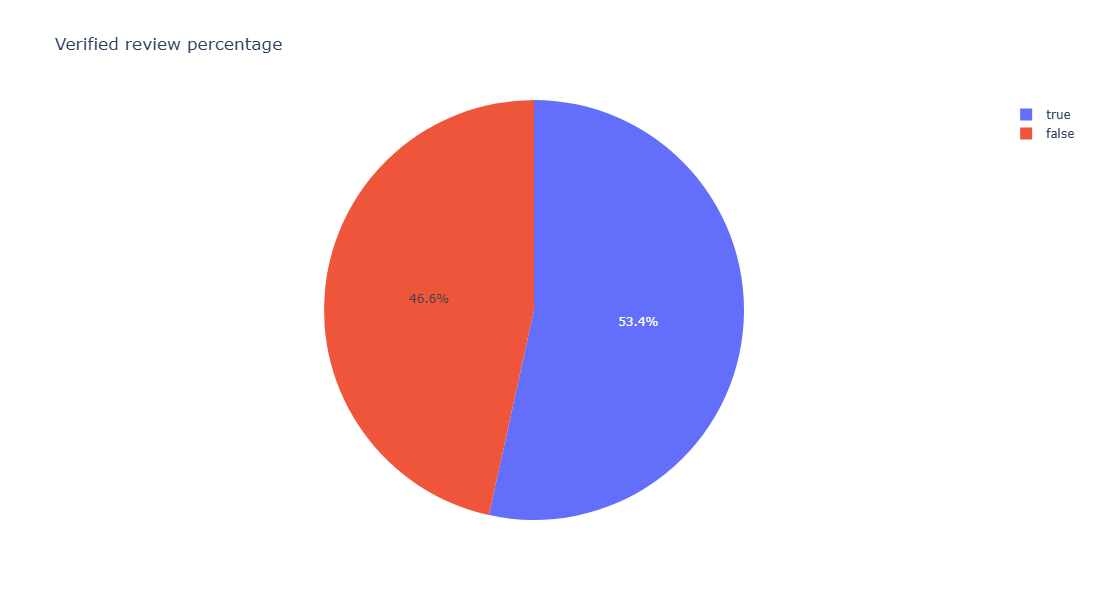

In [ ]:
review_ver_df = flight_df.groupby('Verified')['Verified'].count().reset_index(name='Total')
fig1 = px.pie(review_ver_df, values='Total', names='Verified', height= 600, width= 600, title='Verified review percentage')
fig1.show()

## Create a pie chart to display the Seat Types Distribution

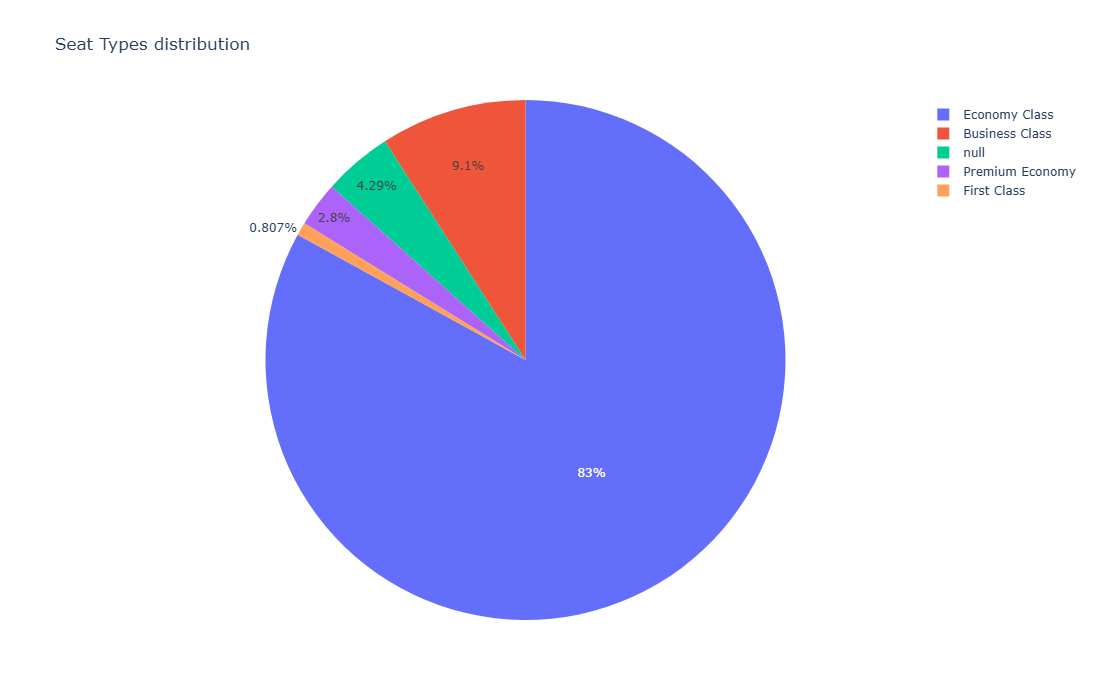

In [ ]:
fig = px.pie(flight_df, names='Seat Type', title='Seat Types distribution',height = 700, width = 700)
fig.show()

## Create a line chart to display the Average Rating Trend Over Time

In [ ]:
Ove_Ver_rate_df_2 = flight_df
Ove_Ver_rate_df_2 = Ove_Ver_rate_df_2.drop(Ove_Ver_rate_df_2[Ove_Ver_rate_df_2['Overall_Rating'] == "n"].index)
Ove_Ver_rate_df_2['Overall_Rating'] = Ove_Ver_rate_df_2['Overall_Rating'].astype(str).astype(float)


In [ ]:
Ove_Ver_rate_df_2.head(5)
print(Ove_Ver_rate_df_2.columns)

Index(['Airline Name', 'Overall_Rating', 'Review_Title', 'Verified', 'Review',
       'Aircraft', 'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown',
       'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
       'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity',
       'Value For Money', 'Recommended'],
      dtype='object')


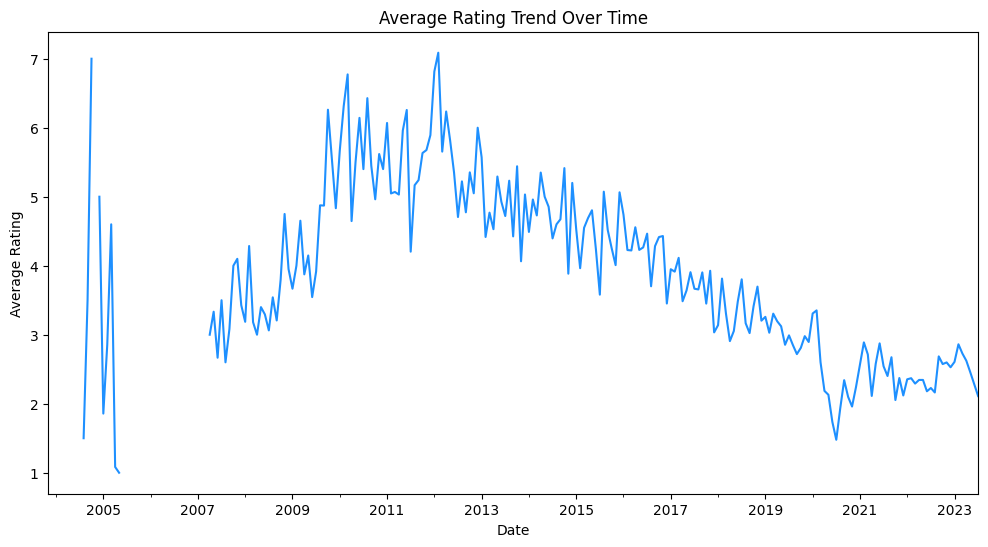

In [ ]:


# Sample date preprocessing function
def clean_date(date_str):
    # Remove ordinal suffixes (e.g., 1st, 2nd, 3rd, 4th)
    date_str = re.sub(r'(\d)(st|nd|rd|th)', r'\1', date_str)
    return pd.to_datetime(date_str, format='%d %B %Y')

if 'Review Date' in Ove_Ver_rate_df_2.columns:
    # Apply cleaning to the 'Review Date' column
    Ove_Ver_rate_df_2['Review Date'] = Ove_Ver_rate_df_2['Review Date'].apply(clean_date)
else:
    print("Error: 'Review Date' column not found!")

# Set the 'Review Date' column as the index
Ove_Ver_rate_df_2.set_index('Review Date', inplace=True)

# Resample and calculate monthly averages
rating_trend = Ove_Ver_rate_df_2.resample('ME')['Overall_Rating'].mean()

# Plot the trend
plt.figure(figsize=(12, 6))
rating_trend.plot(kind='line', color='dodgerblue')
plt.title('Average Rating Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.show()


## Create a grouped bar chart to have Verified vs Unverified in Overall Rating

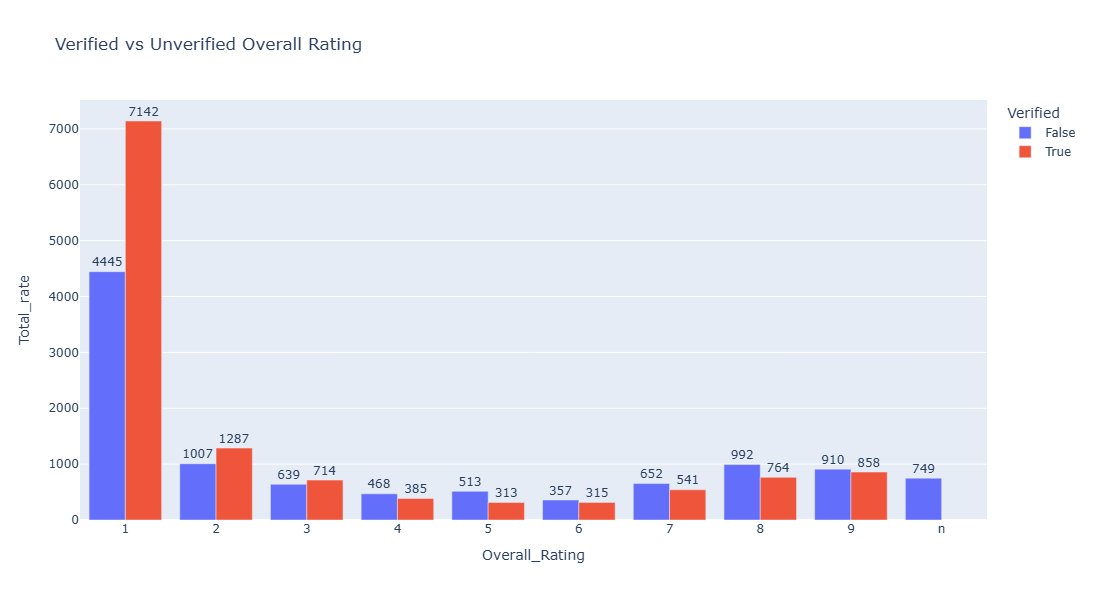

In [ ]:
Ove_Ver_rate_df = flight_df.groupby(['Overall_Rating','Verified']).size().reset_index(name='Total_rate')
fig = px.bar(Ove_Ver_rate_df,
             x="Overall_Rating",
             y="Total_rate",
             color="Verified",
             height= 600,
             width= 1000,
             text_auto=True,
             barmode='group',
            title="Verified vs Unverified Overall Rating",
         )
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

## Create a Stack bar chart to check the Percentage of Recommendations by Seat Type

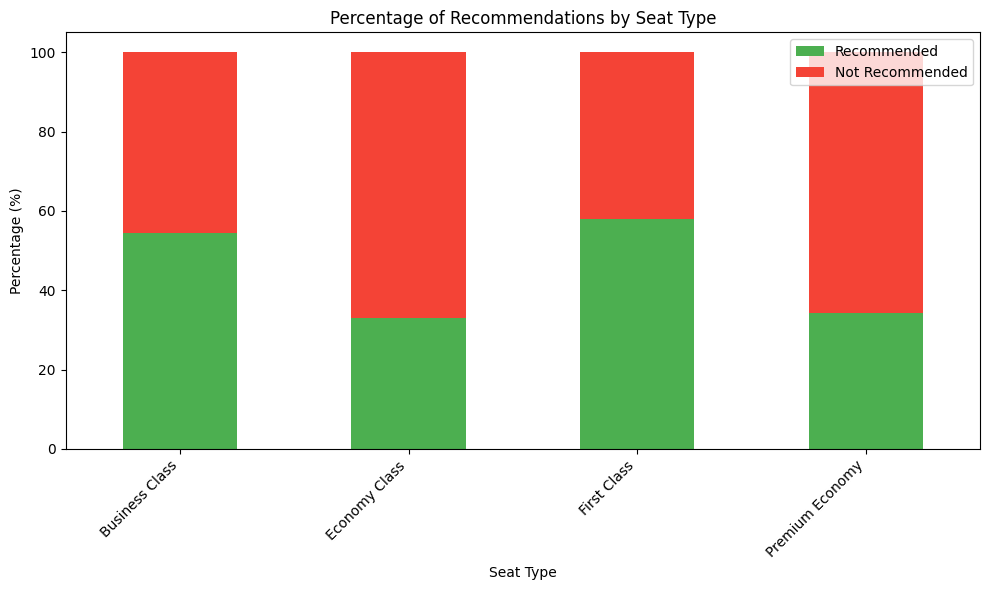

In [ ]:
# Calculate the number of 'Yes' and 'No' recommendations for each Seat Type
recommendation_data = flight_df.groupby(['Seat Type', 'Recommended']).size().unstack(fill_value=0)
recommendation_data['Total'] = recommendation_data['yes'] + recommendation_data['no']

# Calculate percentages
recommendation_data['Yes %'] = (recommendation_data['yes'] / recommendation_data['Total']) * 100
recommendation_data['No %'] = (recommendation_data['no'] / recommendation_data['Total']) * 100

# Plot the stacked bar chart
recommendation_data[['Yes %', 'No %']].plot(kind='bar', stacked=True, color=['#4CAF50', '#F44336'], figsize=(10, 6))

# Improve plot aesthetics
plt.title('Percentage of Recommendations by Seat Type')
plt.xlabel('Seat Type')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(['Recommended', 'Not Recommended'], loc='upper right')
plt.tight_layout()
plt.show()


## Create a Violin Chart for the Overall Ratings by Recommendation (Yes or No)

C:\Users\DELL\AppData\Local\Temp\ipykernel_55796\398300237.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




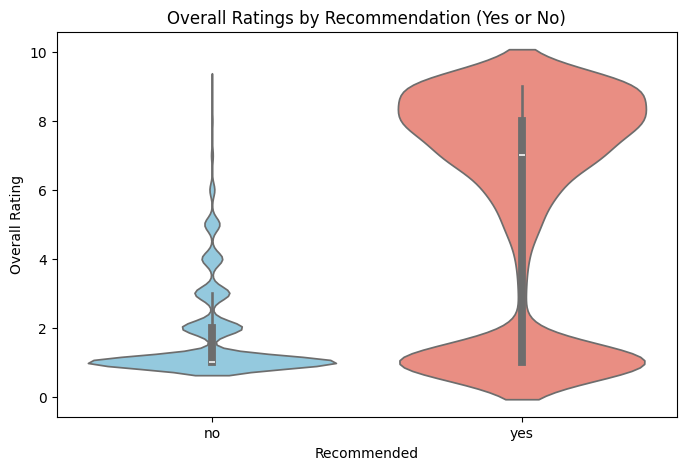

In [ ]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=Ove_Ver_rate_df_2.sort_values('Overall_Rating', ascending=True), x='Recommended', y='Overall_Rating', palette=['skyblue', 'salmon'])
plt.title('Overall Ratings by Recommendation (Yes or No)')
plt.xlabel('Recommended')
plt.ylabel('Overall Rating')
plt.show()


## Create the bar chart that displays the Average Ratings By Type Of Traveller

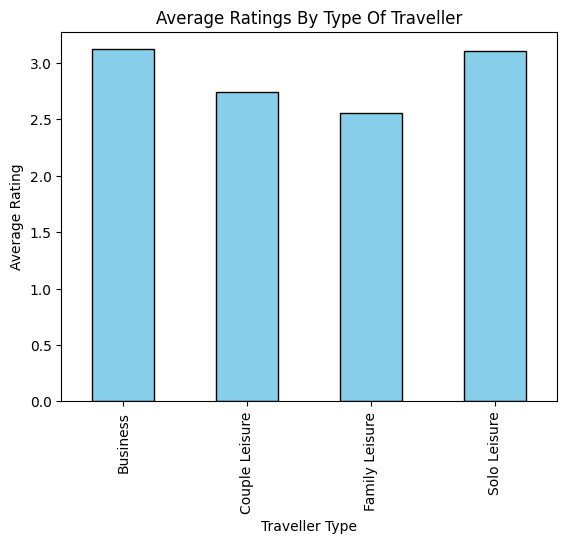

In [ ]:
average_ratings = Ove_Ver_rate_df_2.groupby('Type Of Traveller')['Overall_Rating'].mean()
average_ratings.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Ratings By Type Of Traveller')
plt.xlabel('Traveller Type')
plt.ylabel('Average Rating')
plt.show()


## Create the bar chart that displays the Average Ratings By Seat Types

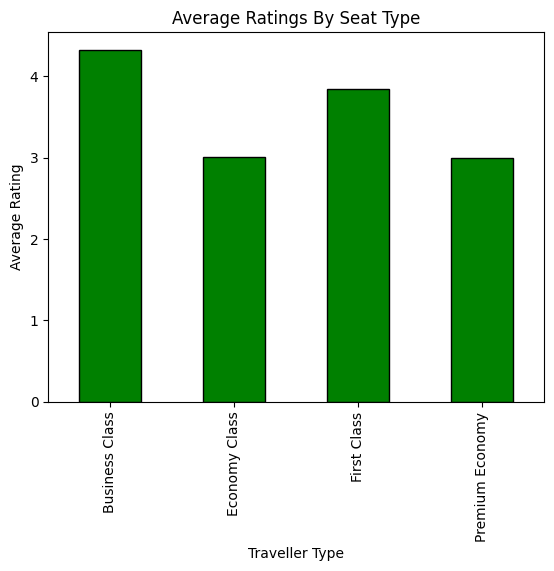

In [ ]:
average_ratings_2 = Ove_Ver_rate_df_2.groupby('Seat Type')['Overall_Rating'].mean()
average_ratings_2.plot(kind='bar', color='green', edgecolor='black')
plt.title('Average Ratings By Seat Type')
plt.xlabel('Traveller Type')
plt.ylabel('Average Rating')
plt.show()


## Create a bar chart display the Best 10 Airlines by Average Performance Score

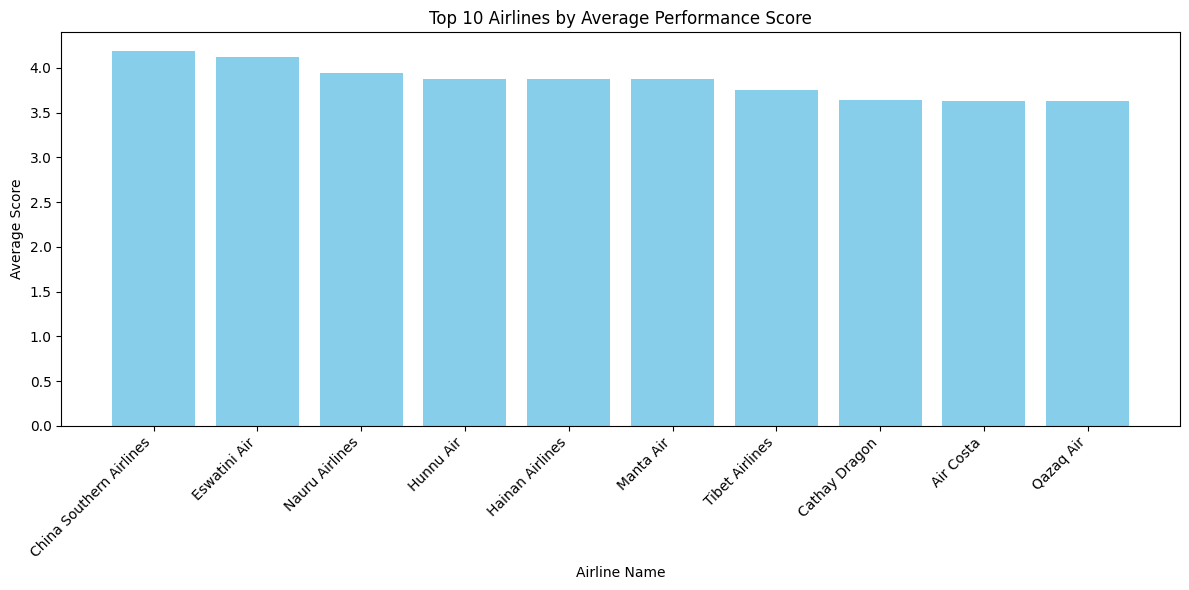

In [ ]:


# Handle missing values in KPIs
kpi_columns = [
    "Seat Comfort",
    "Cabin Staff Service",
    "Food & Beverages",
    "Ground Service",
    "Inflight Entertainment",
    "Wifi & Connectivity",
    "Value For Money",
    "Overall_Rating"
]

# Convert KPI columns to numeric, coercing errors to NaN
Ove_Ver_rate_df_2[kpi_columns] = Ove_Ver_rate_df_2[kpi_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

# Calculate the total KPI scores for each airline
total_kpi_performance = Ove_Ver_rate_df_2.groupby("Airline Name")[kpi_columns].sum()

# Count the number of reviews for each airline
review_counts = Ove_Ver_rate_df_2.groupby("Airline Name")["Overall_Rating"].count()

# Normalize the KPI scores by the number of reviews
normalized_kpi_performance = total_kpi_performance.div(review_counts, axis=0)
normalized_kpi_performance["Number of Reviews"] = review_counts

# Calculate an overall average score for each airline
normalized_kpi_performance["Average Score"] = normalized_kpi_performance[kpi_columns].mean(axis=1)

# Sort airlines by the average score
top_10_airlines = normalized_kpi_performance.sort_values(by="Average Score", ascending=False).head(10)

# Plot the top 10 airlines and their normalized average scores
plt.figure(figsize=(12, 6))
plt.bar(top_10_airlines.index, top_10_airlines["Average Score"], color="skyblue")
plt.title("Top 10 Airlines by Average Performance Score")
plt.xlabel("Airline Name")
plt.ylabel("Average Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Create a bar chart display the Worst 10 Airlines by Average Performance Score

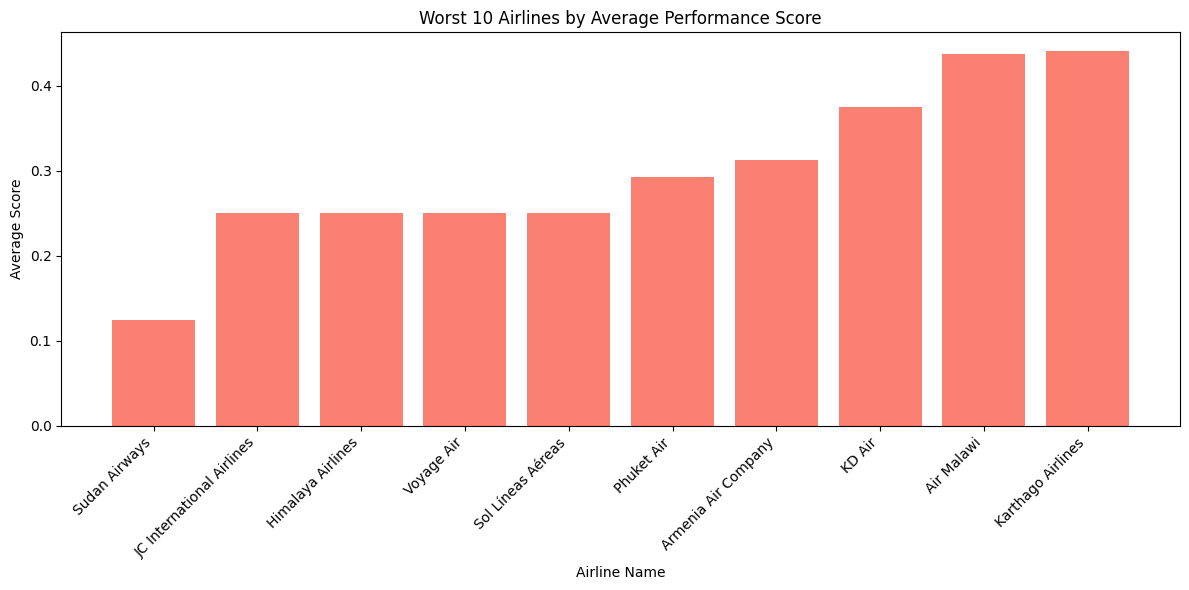

In [ ]:
# Sort airlines by the average score in ascending order for the worst 10 airlines
worst_10_airlines = normalized_kpi_performance.sort_values(by="Average Score", ascending=True).head(10)

# Plot the worst 10 airlines and their normalized average scores
plt.figure(figsize=(12, 6))
plt.bar(worst_10_airlines.index, worst_10_airlines["Average Score"], color="salmon")
plt.title("Worst 10 Airlines by Average Performance Score")
plt.xlabel("Airline Name")
plt.ylabel("Average Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Create a group bar chart for Average Ratings for Verified and Unverified Reviews Across KPIs

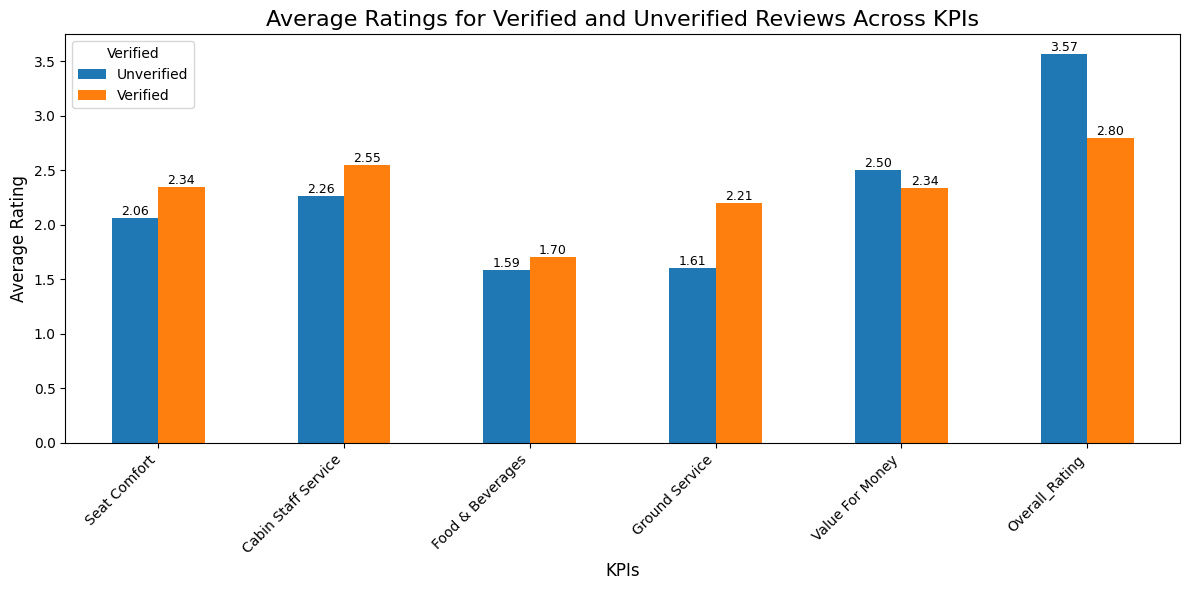

In [ ]:


# Select KPI columns
kpi_columns = ["Seat Comfort", "Cabin Staff Service", "Food & Beverages", "Ground Service", "Value For Money", "Overall_Rating"]

# Group by "Verified" status and calculate the average for each KPI
average_ratings = Ove_Ver_rate_df_2.groupby("Verified")[kpi_columns].mean()

# Visualization
ax = average_ratings.transpose().plot(kind="bar", figsize=(12, 6))
plt.title("Average Ratings for Verified and Unverified Reviews Across KPIs", fontsize=16)
plt.xlabel("KPIs", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.legend(title="Verified", labels=["Unverified", "Verified"], fontsize=10)

# Add numbers on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9)

plt.tight_layout()
plt.show()

## Create a Correlation Matrix

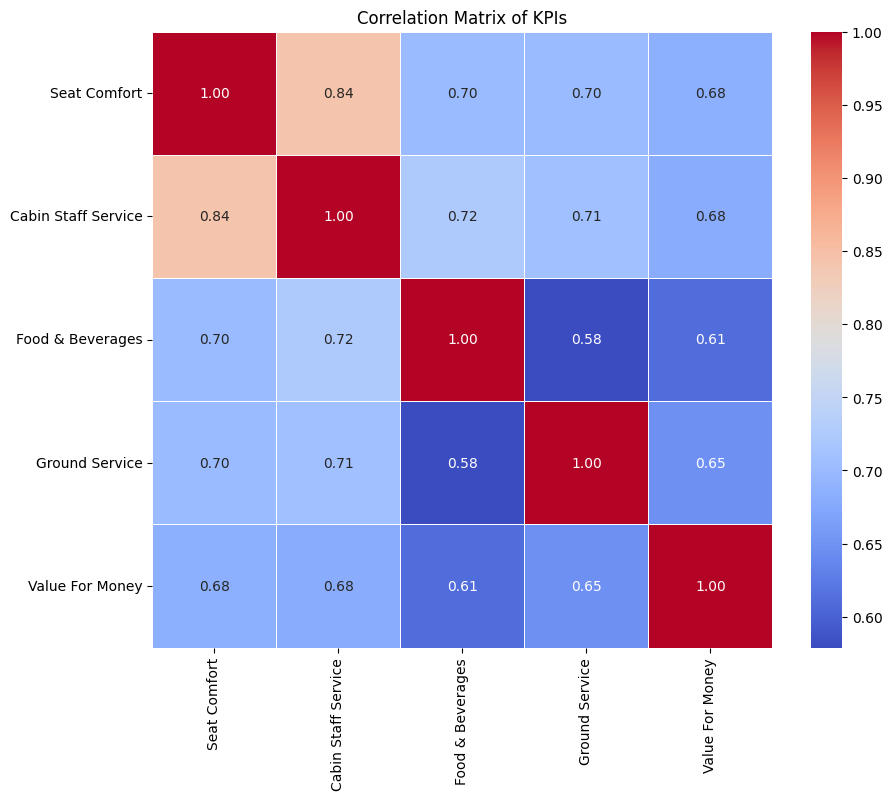

In [ ]:
# Select KPI columns and handle missing values
performance_columns = [
    "Seat Comfort",
    "Cabin Staff Service",
    "Food & Beverages",
    "Ground Service",
#    "Inflight Entertainment",
 #   "Wifi & Connectivity",
    "Value For Money"
]
kpi_data = flight_df[performance_columns].fillna(0)

# Calculate the correlation matrix
correlation_matrix = kpi_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Matrix of KPIs")
plt.show()

## Create histograms to display the distribution of all airline review results

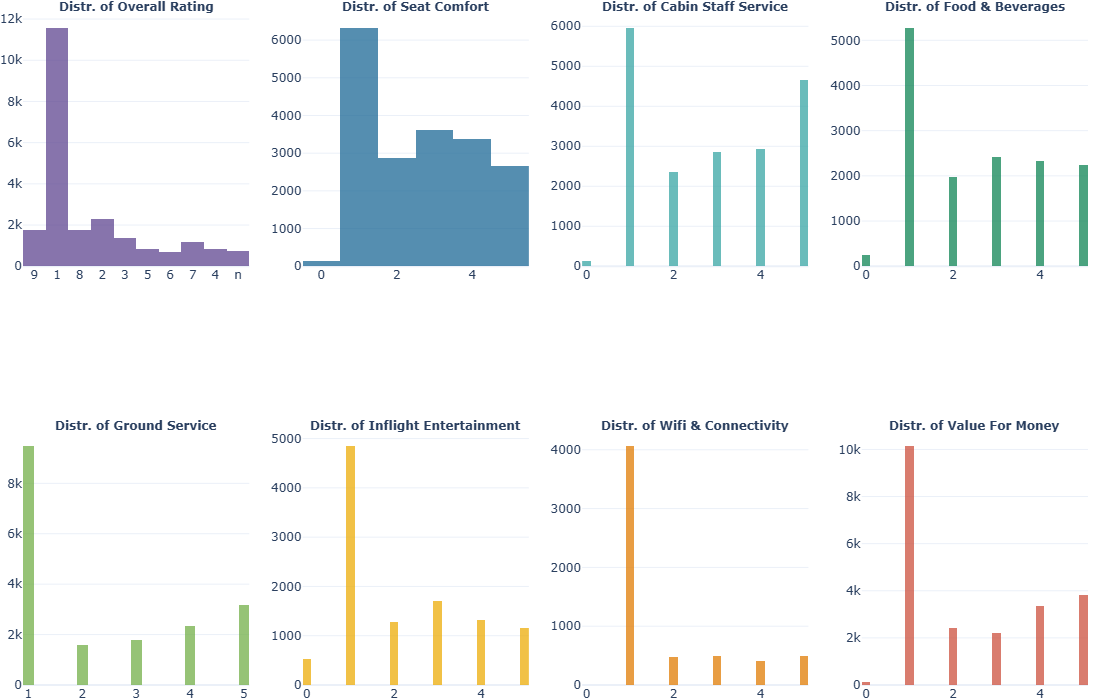

In [ ]:
fig = make_subplots(
    rows=2, cols=4,
    subplot_titles=(
        '<b>Distr. of Overall Rating</b>', '<b>Distr. of Seat Comfort</b>',
        '<b>Distr. of Cabin Staff Service</b>', '<b>Distr. of Food & Beverages</b>',
        '<b>Distr. of Ground Service</b>', '<b>Distr. of Inflight Entertainment</b>',
        '<b>Distr. of Wifi & Connectivity</b>', '<b>Distr. of Value For Money</b>'
    )
)

# Add traces with floating text on bars using text_auto=True
fig.add_trace(go.Histogram(x=flight_df['Overall_Rating'], nbinsx=30), row=1, col=1)
fig.add_trace(go.Histogram(x=flight_df['Seat Comfort']), row=1, col=2)
fig.add_trace(go.Histogram(x=flight_df['Cabin Staff Service'], nbinsx=30), row=1, col=3)
fig.add_trace(go.Histogram(x=flight_df['Food & Beverages'], nbinsx=30), row=1, col=4)
fig.add_trace(go.Histogram(x=flight_df['Ground Service'], nbinsx=30), row=2, col=1)
fig.add_trace(go.Histogram(x=flight_df['Inflight Entertainment'], nbinsx=30), row=2, col=2)
fig.add_trace(go.Histogram(x=flight_df['Wifi & Connectivity'], nbinsx=30), row=2, col=3)
fig.add_trace(go.Histogram(x=flight_df['Value For Money'], nbinsx=30), row=2, col=4)

# Update visual layout
fig.update_layout(
    showlegend=False,
    width=1000,
    height=700,
    autosize=False,
    margin=dict(t=15, b=0, l=10, r=5),
    template="plotly_white",
    colorway=px.colors.qualitative.Prism,
)

# Update font size for subplot titles
fig.update_annotations(font_size=12)

# Reduce opacity
fig.update_traces(opacity=0.75)

# Show figure
fig.show()

# Machine Learning Section
## Perform the Sentiment Analysis using VADER

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
res = {}
for i, row in tqdm(flight_df.iterrows(), total=len(df)):
    text = row['Review']
    index = i
    res[index] = sia.polarity_scores(text)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
analyzer = SentimentIntensityAnalyzer()
flight_df['Overall_Rating'] = pd.to_numeric(flight_df['Overall_Rating'], errors='coerce')
# Define sentiment labels based on Overall_Rating
def categorize_rating(rating):
     """
    Categorizes a numerical rating into Positive, "Neutral,or "Negative.

    Parameters:
        rating (int): The numerical rating to categorize. Expected to be between 0 and 10.

    Returns:
        str: The category of the rating:
             - "Positive" for ratings 7 or higher.
             - "Neutral" for ratings between 4 and 6.
             - "Negative" for ratings less than 4.
    """
    if rating >= 7:
        return "Positive"
    elif rating >= 4:
        return "Neutral"
    else:
        return "Negative"

# Define sentiment labels based on VADER's compound score
def categorize_vader(compound_score):
      """
    Categorizes sentiment based on VADER's compound score.

    Parameters:
        compound_score (float): The VADER compound score, typically ranging from -1 to 1.

    Returns:
        str: The sentiment category based on the compound score:
             - "Positive" for scores greater than or equal to 0.05.
             - "Negative" for scores less than or equal to -0.05.
             - "Neutral" for scores between -0.05 and 0.05.
    """
    if compound_score >= 0.05:
        return "Positive"
    elif compound_score <= -0.05:
        return "Negative"
    else:
        return "Neutral"


flight_df['compound'] = flight_df['Review'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

flight_df['Rating_Sentiment'] = flight_df['Overall_Rating'].apply(categorize_rating)
flight_df['VADER_Sentiment'] = flight_df['compound'].apply(categorize_vader)

# Calculate accuracy
accuracy = np.mean(flight_df['Rating_Sentiment'] == flight_df['VADER_Sentiment'])
print(f"VADER Sentiment Analysis Accuracy: {accuracy:.2%}")

VADER Sentiment Analysis Accuracy: 65.32%


## Display Word Cloud for positive and negative reviews

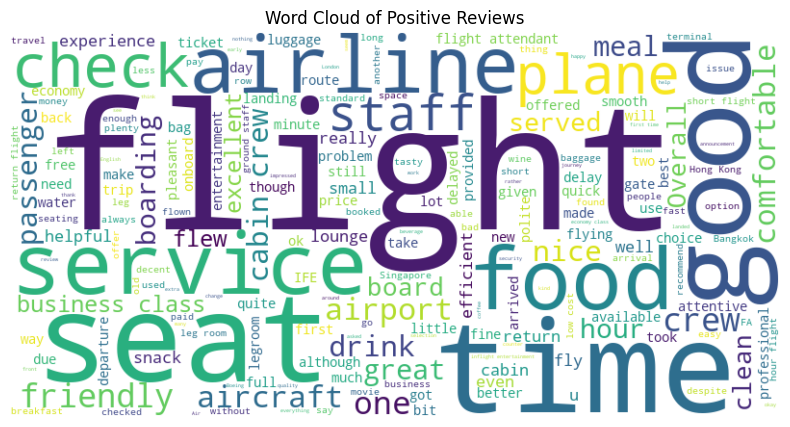

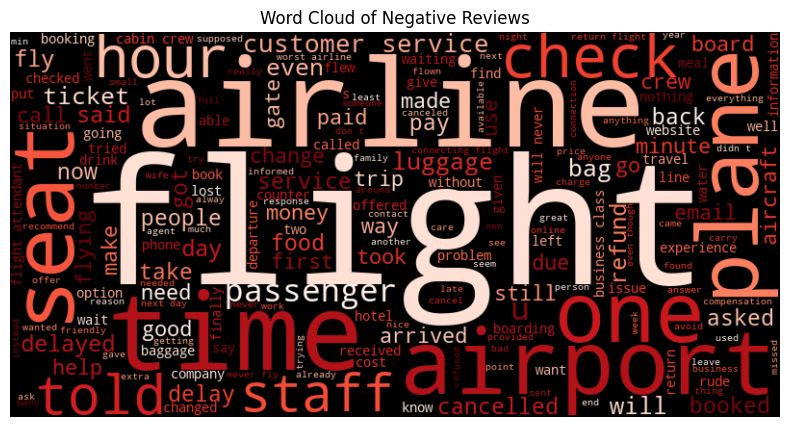

In [ ]:
# Word cloud for positive reviews
positive_reviews = ' '.join(flight_df[flight_df['Rating_Sentiment'] == 'Positive']['Review'].dropna())
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Display the word cloud for positive reviews
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews')
plt.show()

# Word cloud for negative reviews
negative_reviews = ' '.join(flight_df[flight_df['Rating_Sentiment'] == 'Negative']['Review'].dropna())
negative_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_reviews)

# Display the word cloud for negative reviews
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Reviews')
plt.show()

In [ ]:
# Filter misclassified rows
misclassified = flight_df[flight_df['Rating_Sentiment'] != flight_df['VADER_Sentiment']]

# Randomly sample 10 misclassified rows for review
sample_misclassified = misclassified.sample(10)

# Display misclassified reviews for manual analysis
for i, row in sample_misclassified.iterrows():
    print(f"Review {i}: {row['Review']}")
    print(f"Overall Rating: {row['Overall_Rating']}, Rating Sentiment: {row['Rating_Sentiment']}, VADER Sentiment: {row['VADER_Sentiment']}")
    print(f"VADER Compound Score: {row['compound']}")
    print("-" * 80)

# Count the occurrences of each misclassification type
misclassification_summary = misclassified.groupby(['Rating_Sentiment', 'VADER_Sentiment']).size()
print("Misclassification Summary:")
print(misclassification_summary)

Review 11365:  If I had any other option - I would not fly Icelandair ever again. In March they cancelled my flight from Gatwick to Keflavik less than a week before the fly date, rebooked me on another flight which was then cancelled again 3 days before the departure even after I contacted their customer service to make sure that it will not be cancelled (they told me that it will 100% not be cancelled cause they're trying to bring all the natives home because of Covid - I'm Icelandic so was reassured by this which was a huge mistake). I ended up buying a last minute flight with EasyJet to get home to my family. So overall it cost me between £1k-£1.5k with the many train tickets I had to buy cause they kept cancelling and the last minute flight. Didn't get my refund until September and that was after I contacted the CEO directly. During summer and easter I kept calling their customer service which just told me that I'm in a queue to get a refund (complete bollocks since people who got 

## Build the LSTM Model

In [ ]:
# Define a function to clean the reviews
def clean_review(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Stem the words
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words]
    # Join back into a single string
    return " ".join(words)

# Apply the cleaning function to the Review column
flight_df['Cleaned_Review'] = flight_df['Review'].apply(clean_review)

# Tokenize and preprocess the cleaned reviews
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(flight_df['Cleaned_Review'])
X = tokenizer.texts_to_sequences(flight_df['Cleaned_Review'])
X = pad_sequences(X, maxlen=100)

# Prepare labels
y = pd.get_dummies(flight_df['Rating_Sentiment']).values

# Build the LSTM model
model = Sequential()
model.add(Embedding(5000, 300))  # Embedding layer
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer
model.add(Dense(3, activation='softmax'))  # Output layer with 3 classes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=25, batch_size=64, validation_split=0.2)


Epoch 1/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 49s 158ms/step - accuracy: 0.7092 - loss: 0.7148 - val_accuracy: 0.7816 - val_loss: 0.5381
Epoch 2/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step - accuracy: 0.7952 - loss: 0.5159 - val_accuracy: 0.7801 - val_loss: 0.5632
Epoch 3/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step - accuracy: 0.8158 - loss: 0.4478 - val_accuracy: 0.7649 - val_loss: 0.5661
Epoch 4/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 44s 153ms/step - accuracy: 0.8499 - loss: 0.3869 - val_accuracy: 0.7658 - val_loss: 0.5999
Epoch 5/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 45s 157ms/step - accuracy: 0.8703 - loss: 0.3312 - val_accuracy: 0.7519 - val_loss: 0.6483
Epoch 6/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step - accuracy: 0.8917 - loss: 0.2895 - val_accuracy: 0.7558 - val_loss: 0.7209
Epoch 7/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.9110 - loss: 0.2436 - val_accuracy: 0.7434 - val_loss: 0.7940
Epoch 8/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 44s 151ms/step - accuracy: 0.9282 - loss: 0

## Create a bar chart to compare the Accuracy for Different ML Algorithms

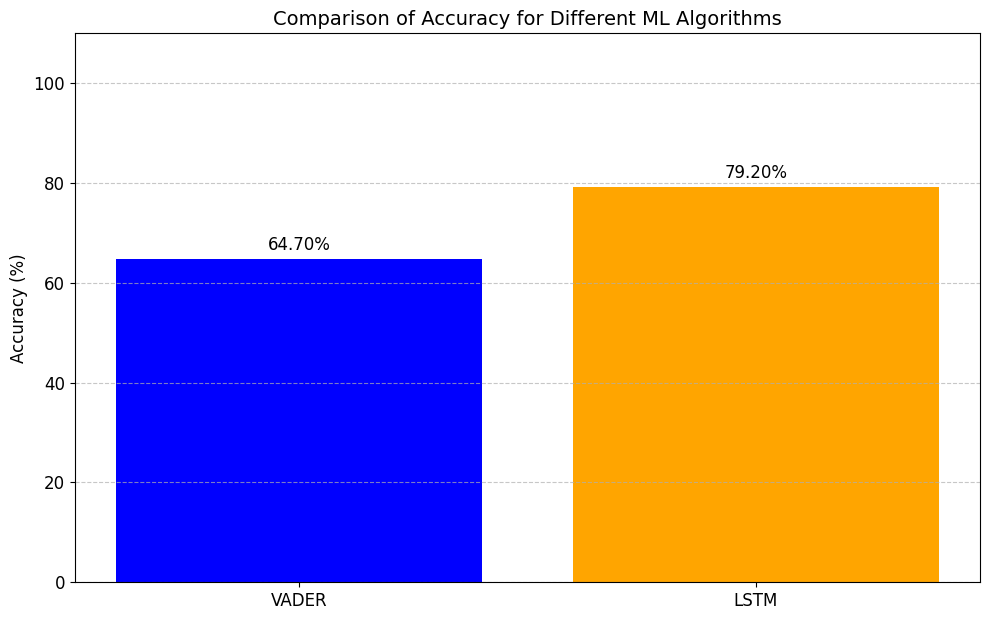

In [ ]:
# Accuracy values for each algorithm
algorithms = ['VADER', 'LSTM']
accuracies = [64.70, 79.20]

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(algorithms, accuracies, color=['blue', 'orange', 'green', 'purple'])

# Add value labels on top of bars
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,  # Shift text label slightly above the bar
        f"{bar.get_height():.2f}%",
        ha='center',
        va='bottom',
        color='black',
        fontsize=12
    )

# Customize the chart
plt.title("Comparison of Accuracy for Different ML Algorithms", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(0, 110)  # Extend y-axis limit to avoid cropping
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add padding to avoid cropping
plt.tight_layout(rect=[0, 0, 1, 1.05])

# Show the chart
plt.show()

In [ ]:
# Identify misclassified reviews
misclassified = flight_df[flight_df['Rating_Sentiment'] != flight_df['VADER_Sentiment']]

# Create a copy for adjustments
adjusted_reviews = misclassified.copy()

# Adjust sentiment based on stricter compound thresholds
def adjust_sentiment(compound_score):
  def adjust_sentiment(compound_score):
    """
    Adjusts sentiment categorization based on high compound scores.

    Parameters:
        compound_score (float): The VADER compound score, typically ranging from -1 to 1.

    Returns:
        str or None: The adjusted sentiment category:
             - "Positive" for scores greater than or equal to 0.8.
             - "Negative" for scores less than or equal to -0.8.
             - None for scores between -0.8 and 0.8.
    """
    if compound_score >= 0.8:
        return "Positive"
    elif compound_score <= -0.8:
        return "Negative"
    else:
        return None

    if compound_score >= 0.8:
        return "Positive"
    elif compound_score <= -0.8:
        return "Negative"
    else:
        return None

# Apply the adjustment
adjusted_reviews['Forced_Sentiment'] = adjusted_reviews['compound'].apply(adjust_sentiment)

# Replace only where Forced_Sentiment is not None
adjusted_reviews['Adjusted_Sentiment'] = adjusted_reviews['Forced_Sentiment'].fillna(adjusted_reviews['VADER_Sentiment'])

# Display results for analysis
print(adjusted_reviews[['Review', 'compound', 'Rating_Sentiment', 'VADER_Sentiment', 'Forced_Sentiment', 'Adjusted_Sentiment']])

# Save to a new DataFrame or file
#adjusted_reviews.to_csv("misclassified_and_adjusted.csv", index=False)

                                                  Review  compound  \
2        Anjouan to Dzaoudzi. A very small airline an...    0.7569   
15       Frankfurt to Ljubljana. Flight was very comf...    0.5563   
23       Two very short flights with Adria Airways fr...    0.9287   
25       Fly only if no other connection, I am a freq...    0.4644   
26       Munich to Ljubljana. Adria Airways as the na...    0.9482   
...                                                  ...       ...   
23037    My son, active duty military, had a connecti...    0.2488   
23038    I bought a flight from Zipair in July. I wil...    0.1531   
23039    Was not informed of needing a PCR test so at...    0.8896   
23044    My issues started before we even flew. I rec...    0.9929   
23049   Zipair is JAL’s budget airline. They don’t ha...    0.9588   

      Rating_Sentiment VADER_Sentiment Forced_Sentiment Adjusted_Sentiment  
2             Negative        Positive             None           Positive  
15   

## fitting the altered LSTM model

In [ ]:

# Load the misclassified data with adjusted sentiments
misclassified_reviews = adjusted_reviews.copy()  # Replace with actual DataFrame if needed

# Filter out rows where Forced_Sentiment is None (no adjustment was needed)
misclassified_reviews = misclassified_reviews[misclassified_reviews['Forced_Sentiment'].notnull()]

# Use 'Adjusted_Sentiment' for training
misclassified_reviews['Final_Sentiment'] = misclassified_reviews['Adjusted_Sentiment']

# Define a function to clean the reviews
def clean_review(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Stem the words
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words]
    # Join back into a single string
    return " ".join(words)

# Apply the cleaning function to the Review column
misclassified_reviews['Cleaned_Review'] = misclassified_reviews['Review'].apply(clean_review)

# Tokenize and preprocess the cleaned reviews
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(misclassified_reviews['Cleaned_Review'])
X = tokenizer.texts_to_sequences(misclassified_reviews['Cleaned_Review'])
X = pad_sequences(X, maxlen=100)

# Prepare labels using the adjusted sentiments
y = pd.get_dummies(misclassified_reviews['Final_Sentiment']).values

# Build the LSTM model
model = Sequential()
model.add(Embedding(5000, 128))  # Embedding layer
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer
model.add(Dense(2, activation='softmax'))  # Output layer with 3 classes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=10, batch_size=64, validation_split=0.3)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 277ms/step - accuracy: 0.8536 - loss: 0.4891 - val_accuracy: 0.8852 - val_loss: 0.3222
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 261ms/step - accuracy: 0.9098 - loss: 0.2439 - val_accuracy: 0.8920 - val_loss: 0.2822
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 284ms/step - accuracy: 0.9440 - loss: 0.1352 - val_accuracy: 0.8911 - val_loss: 0.2746
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 265ms/step - accuracy: 0.9874 - loss: 0.0522 - val_accuracy: 0.8970 - val_loss: 0.3444
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.9945 - loss: 0.0243 - val_accuracy: 0.9013 - val_loss: 0.4183
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 283ms/step - accuracy: 0.9936 - loss: 0.0234 - val_accuracy: 0.8970 - val_loss: 0.3896
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 263ms/step - accuracy: 0.9981 - loss: 0.0104 - val_accuracy: 0.9055 - val_loss: 0.4846
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 261ms/step - accuracy: 0.9990 - loss: 0.0047 - val_accu

In [ ]:
_, accuracy_lstm = model.evaluate(X, y, verbose=0)
print(f"Test Accuracy: {accuracy_lstm * 100:.2f}%")

Test Accuracy: 96.73%


## Create a bar chart that display the percentage of an altered LSTM model

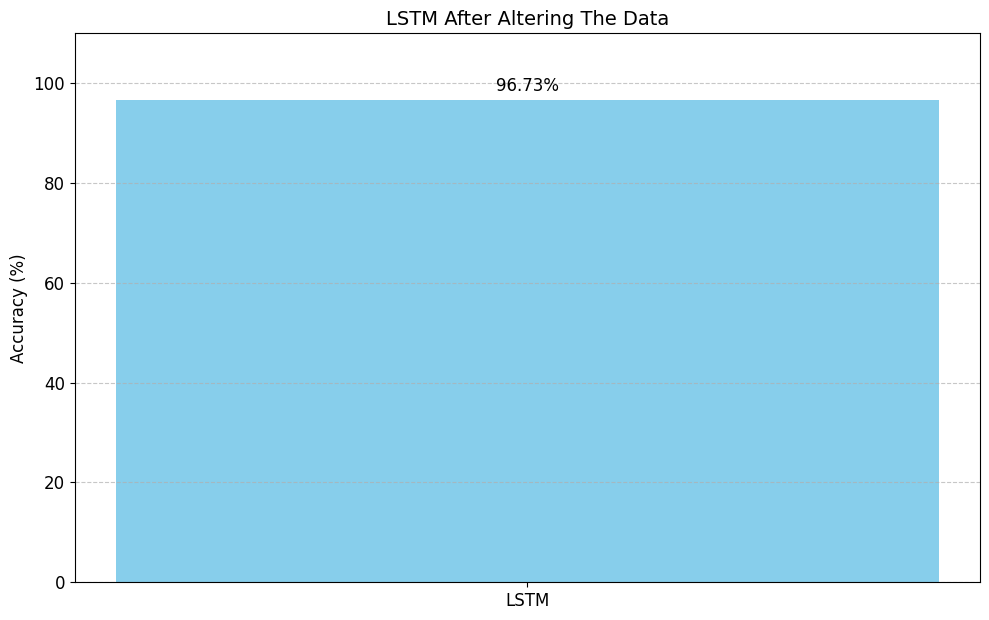

In [ ]:
# Accuracy values for each algorithm
algorithms = [ 'LSTM']
accuracies = [accuracy_lstm]  # Replace these values with your calculated accuracies

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(algorithms, accuracy_lstm*100, color=['skyblue'])

# Add value labels on top of bars
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,  # Shift text label slightly above the bar
        f"{bar.get_height():.2f}%",
        ha='center',
        va='bottom',
        color='black',
        fontsize=12
    )

# Customize the chart
plt.title("LSTM After Altering The Data", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(0, 110)  # Extend y-axis limit to avoid cropping
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add padding to avoid cropping
plt.tight_layout(rect=[0, 0, 1, 1.05])

# Show the chart
plt.show()